In [1]:
# for plotting, run: pip install pandas matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.signal import medfilt, sosfilt, ellip, iirnotch, freqz, filtfilt
from sklearn.preprocessing import MinMaxScaler

import wfdb
%pip install gluonts

from gluonts.dataset.pandas import PandasDataset
from chronos_mlx import ChronosPipeline
from chronos_utils import *

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    dtype="bfloat16",
)

/Users/pm-w/Documents/Research/Foundational Models/FL-GitHub/Time-Series/.venv/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/pm-w/Documents/Research/Foundational Models/FL-GitHub/Time-Series/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/pm-w/Documents/Research/Foundational Models/FL-GitHub/Time-Series/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
samples_local_path = '../data/samples/'
observation_names = list(set([x[:-4] for x in os.listdir(samples_local_path)]))
observation_names

['100']

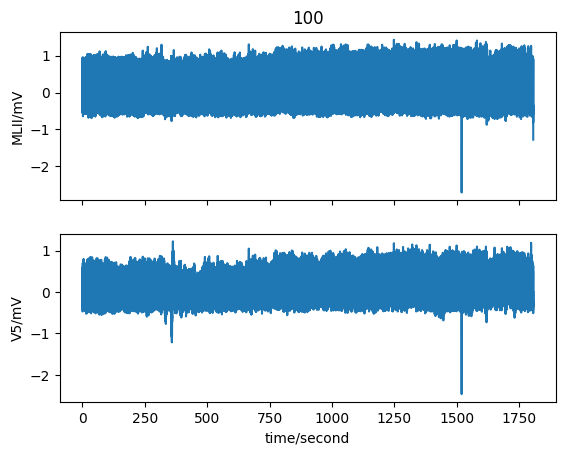

In [3]:

for filename_base in observation_names:
    file_path = samples_local_path + filename_base

    record = wfdb.rdrecord(file_path)

    # plot the record to screen
    wfdb.plot_wfdb(record=record, title=f'{filename_base}')

In [4]:
# Raw Data Representation


MLII = create_record(filepath = file_path, column_subset=['MLII'])

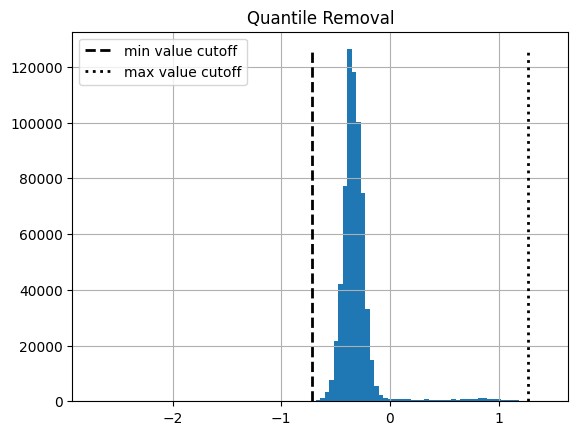

In [5]:
MLII_quant = quantile_outlier_removal(MLII, column_name = 'MLII', quantile_min=0.00001, quantile_max = 0.99999, plot = True)

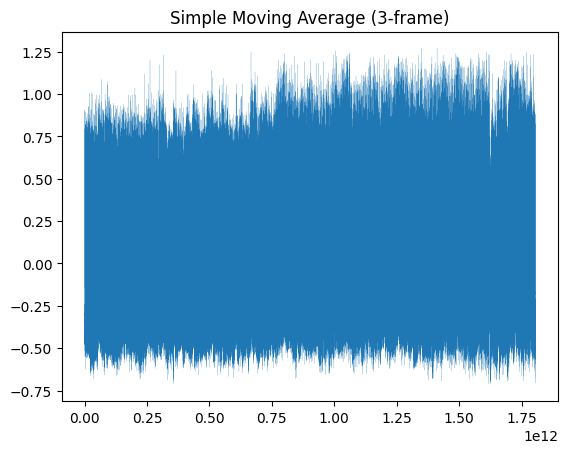

In [6]:

# With Simple Moving Average (3 frame window)

MLII_SMA = simple_moving_average(MLII_quant, 3, True)

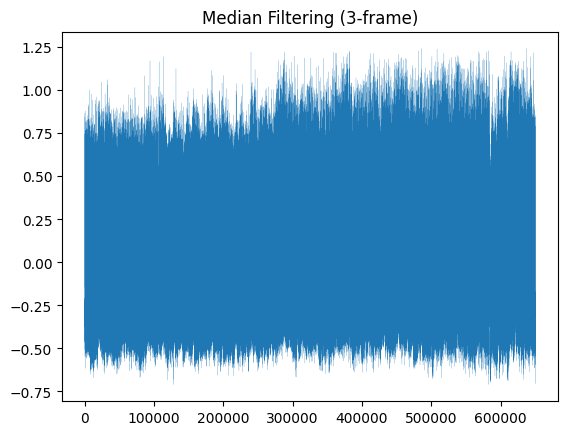

In [7]:
# With median filtering

MLII_medfilt = median_filtering(MLII_SMA['MLII'],3)

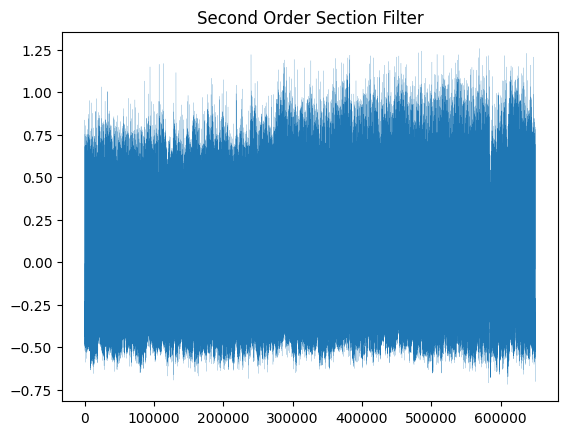

In [8]:
# With second-order section filter

MLII_sos = sos_filter(MLII_medfilt, plot = True)

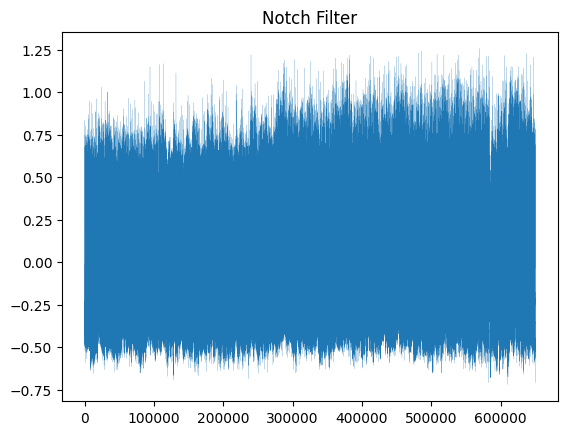

In [9]:
MLII_notch = notch_filtering(MLII_sos, plot = True)

In [10]:

final_df = normalizer(MLII_notch)

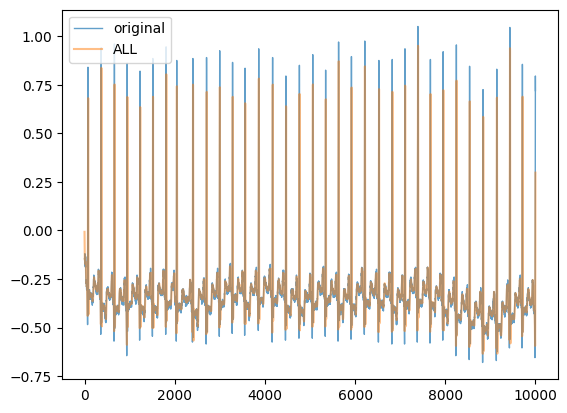

In [11]:
#Show difference from original and processed signal

plt.plot(MLII.values[:10000], label = 'original', alpha = 0.7, linewidth = 1)
plt.plot(MLII_notch[:10000], label ='ALL', alpha = 0.5)
plt.legend()
plt.show()


In [12]:
####  The following Code is not likely to work without further development.  
####  Left here as a starting place for passing processed data.

In [13]:
# plt.figure(figsize=(20, 15))
# plt.rcParams.update({'font.size': 15})

MLII_df = pd.DataFrame(final_df, index = MLII.index)
MLII_df

# ax = plt.subplot()
context_start_position = 1000
context_end_position = 1950
prediction_length = 50
ts_full = MLII_df.iloc[context_start_position:context_end_position+prediction_length]

context = MLII_df.values[context_start_position:context_end_position].flatten()

ts_values = MLII_df.values[context_start_position:context_end_position+prediction_length].flatten()
ts_index = MLII_df.index[context_start_position:context_end_position+prediction_length]

forecast_index = MLII_df.index[context_end_position:context_end_position+prediction_length]

forecast = pipeline.predict(
    context,
    prediction_length,
    num_samples=20,
    temperature=1.0,
    top_k=100,
    top_p=1,
) # forecast shape: [num_series, num_samples, prediction_length]


low, median, high = np.quantile(forecast[0], [0.1, 0.5, 0.9], axis=0)

In [14]:
result_df = pd.DataFrame(data = {'low':low, 'median':median, 'high':high}, index = forecast_index)

In [15]:
ts_full = MLII_df.iloc[context_start_position:context_end_position+prediction_length].rename(columns = {0:'full'})

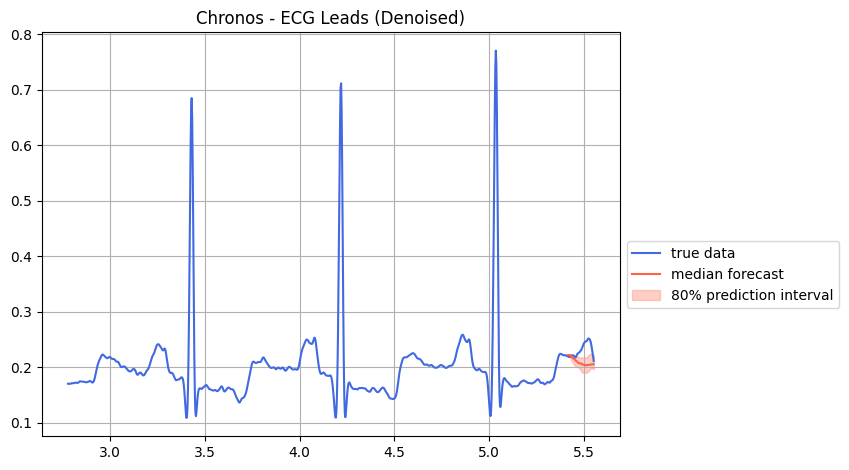

In [16]:
fig, ax = plt.subplots()

ax.plot(ts_full.index.total_seconds(), ts_full['full'].values, color="royalblue", label="true data")
ax.plot(result_df.index.total_seconds(), result_df['median'], color="tomato", label="median forecast")
ax.fill_between(result_df.index.total_seconds(), result_df['low'], result_df['high'], color="tomato", alpha=0.3, label="80% prediction interval")
ax.set_title('MLII')    

ax.grid()

plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Chronos - ECG Leads (Denoised)')
plt.show()